# Epidemic Simulation with Vaccination Campaign

This notebook demonstrates how to run and analyze epidemic simulations using network graphs. The simulation models:
- Disease transmission through a social network
- Vaccination campaigns with individual-level heterogeneity
- Multiple outcomes: infection, testing, and death
- Unmeasured confounding effects
- Survival analysis using Cox proportional hazards models

## Features
- Network-based epidemic modeling
- Time-varying vaccination campaigns  
- Multiple outcome analysis
- Survival analysis with proper event timing
- Parameter sensitivity testing
- Monte Carlo simulation for uncertainty quantification

## 1. Import Libraries and Load Simulation Code

In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load simulation functions from utils.py
from utils import (
    generate_random_graph, 
    assign_initial_states, 
    assign_initial_infected,
    vaccination_campaign,
    simulate_outbreak,
    estimate_models,
    run_simulation
)

print("All libraries and functions loaded successfully!")

All libraries and functions loaded successfully!


## 2. Set Simulation Parameters

Define the default parameters for our epidemic simulation.

In [2]:
# Default simulation parameters
PARAMS = {
    'num_nodes': 10000,           # Size of the population
    'edges_per_node': 10,         # Average connections per person
    'infection_prob': 0.04,      # Base probability of transmission per contact
    'recovery_prob': 0.1,        # Probability of recovery per time step
    'death_prob': 0.01,          # Probability of death per time step (for infected)
    'testing_prob': 0.3,         # Base probability of being tested
    'vaccine_efficacy': 0.6,     # Vaccine effectiveness (80%)
    'num_initial_infected': 50,   # Number of initially infected individuals
    'steps': 100                 # Number of time steps to simulate
}

# Create a basic vaccination schedule (5% vaccination rate for first 50 days)
basic_vaccination_schedule = [0.05] * 50 + [0.0] * 50

print("Simulation Parameters:")
for key, value in PARAMS.items():
    print(f"  {key}: {value}")
print(f"\nBasic vaccination schedule: 5% daily for first 50 days, then 0%")

Simulation Parameters:
  num_nodes: 10000
  edges_per_node: 10
  infection_prob: 0.04
  recovery_prob: 0.1
  death_prob: 0.01
  testing_prob: 0.3
  vaccine_efficacy: 0.6
  num_initial_infected: 50
  steps: 100

Basic vaccination schedule: 5% daily for first 50 days, then 0%


## 3. Run Basic Simulation

Let's run a basic simulation to see how the epidemic progresses with a vaccination campaign.

Running basic simulation...
Step 0: Infected: 55, Recovered: 4, Dead: 0, Tested: 4, Vaccinated: 525
Step 10: Infected: 307, Recovered: 173, Dead: 15, Tested: 162, Vaccinated: 4410
Step 20: Infected: 669, Recovered: 692, Dead: 57, Tested: 453, Vaccinated: 6610
Step 30: Infected: 916, Recovered: 1513, Dead: 144, Tested: 848, Vaccinated: 7786
Step 40: Infected: 833, Recovered: 2493, Dead: 224, Tested: 1196, Vaccinated: 8511
Step 50: Infected: 621, Recovered: 3276, Dead: 287, Tested: 1413, Vaccinated: 8923
Step 60: Infected: 414, Recovered: 3799, Dead: 347, Tested: 1546, Vaccinated: 8923
Step 70: Infected: 299, Recovered: 4146, Dead: 387, Tested: 1638, Vaccinated: 8923
Step 80: Infected: 181, Recovered: 4390, Dead: 410, Tested: 1694, Vaccinated: 8923
Step 90: Infected: 85, Recovered: 4530, Dead: 428, Tested: 1712, Vaccinated: 8923


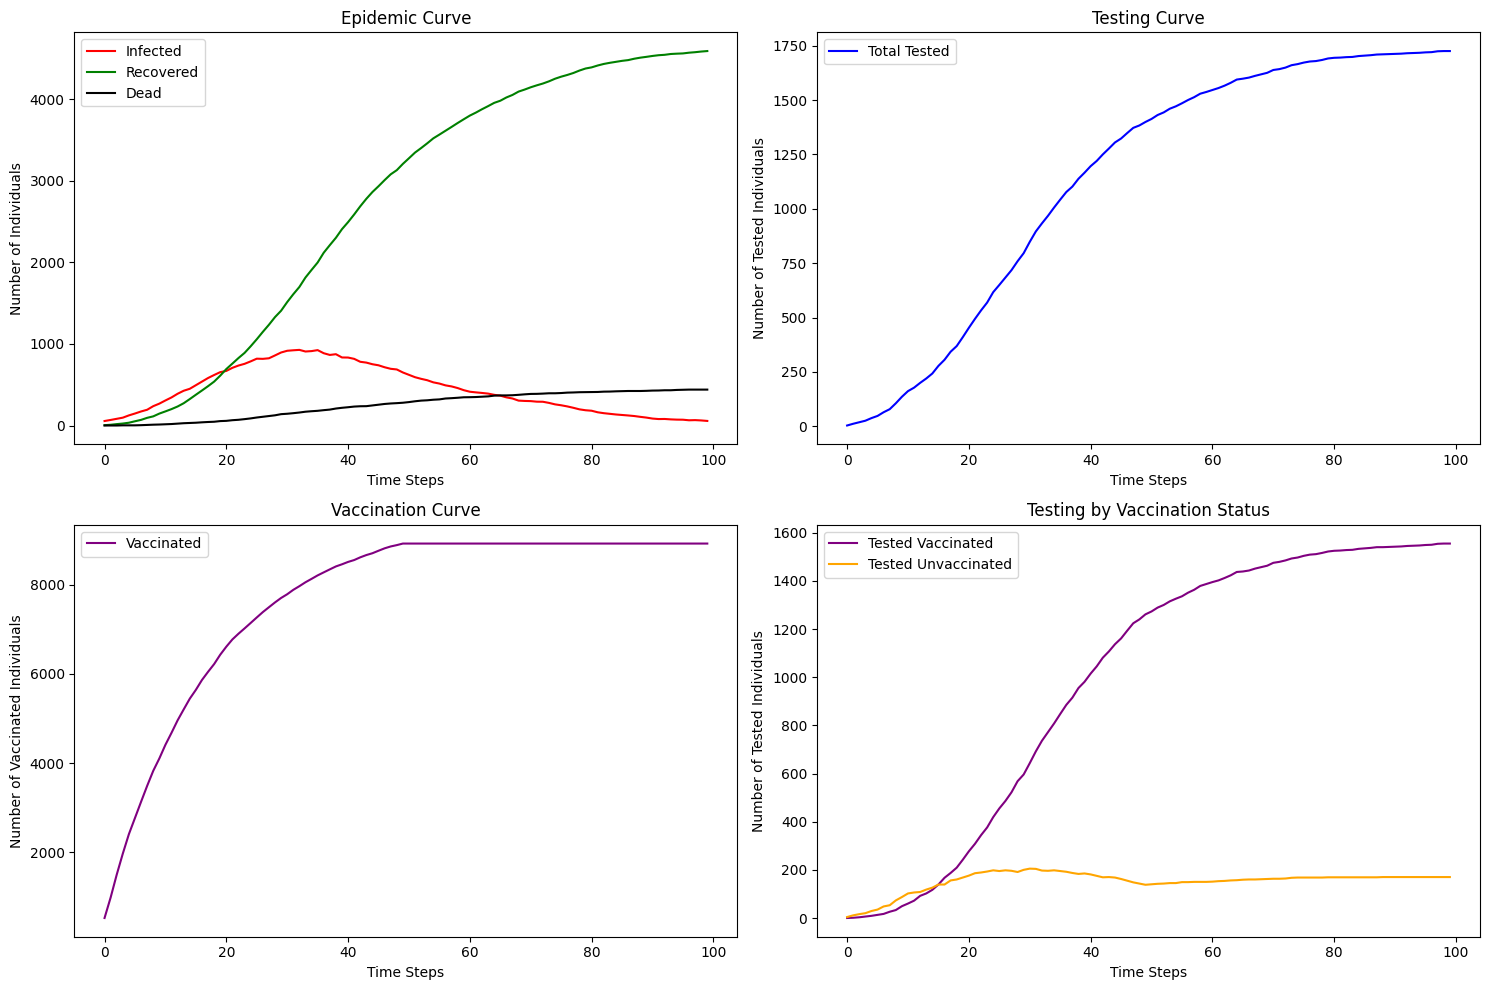

Hazard Ratios for tested:
  Without unmeasured confounder: 0.774
  With unmeasured confounder: 0.581
  Number vaccinated: 8923/10000 (89.2%)

=== BASIC SIMULATION RESULTS ===
Hazard Ratio (without unmeasured confounder): 0.774
Hazard Ratio (with unmeasured confounder): 0.581
Analyzed outcome: tested


In [3]:
# Run basic simulation with default parameters
print("Running basic simulation...")
G_basic, results_basic = run_simulation(
    **PARAMS,
    vaccination_schedule=basic_vaccination_schedule,
    outcome='tested',  # Analyze testing as outcome
    plot=True,
    print_progress=True
)

print("\n=== BASIC SIMULATION RESULTS ===")
print(f"Hazard Ratio (without unmeasured confounder): {results_basic['hr_basic']:.3f}")
print(f"Hazard Ratio (with unmeasured confounder): {results_basic['hr_with_unmeasured_confounder']:.3f}")
print(f"Analyzed outcome: {results_basic['outcome']}")

## 4. Visualize Network Structure

Let's visualize the network graph to understand the structure and final states of individuals.

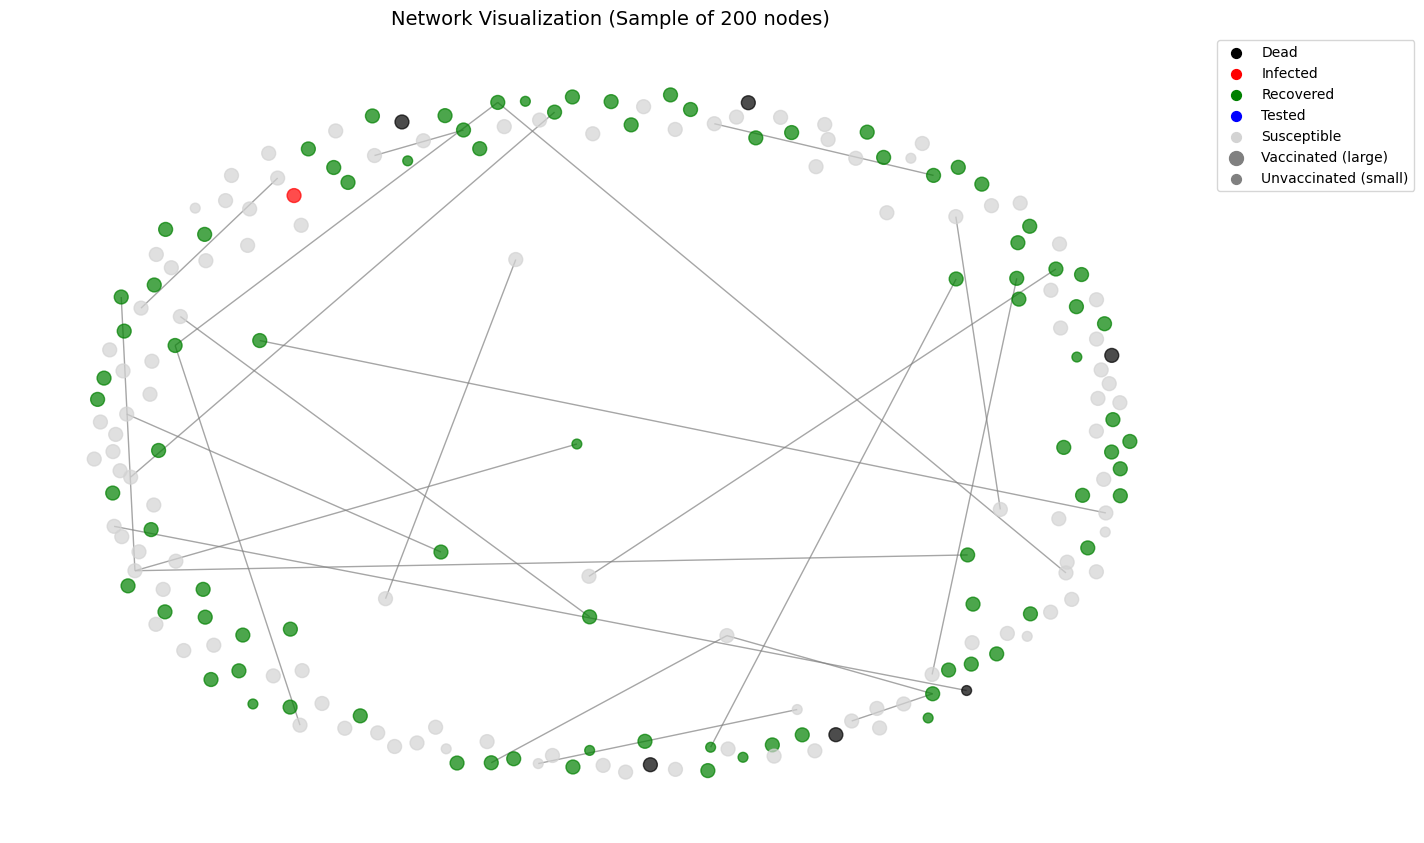


=== FINAL POPULATION STATE ===
Total population: 10000
Vaccinated: 8923 (89.2%)
Tested positive: 1725 (17.2%)
Ever infected: 5086
Recovered: 4590
Dead: 440
Still susceptible: 4914


In [4]:
# Create network visualization showing final states
def visualize_network(G, sample_size=200):
    """Visualize a sample of the network showing node states and vaccination status"""
    
    # Sample nodes for visualization (full network too dense to see clearly)
    nodes_to_show = random.sample(list(G.nodes()), min(sample_size, len(G.nodes())))
    G_sub = G.subgraph(nodes_to_show)
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, k=1, iterations=50)
    
    # Define colors for different states
    node_colors = []
    for node in G_sub.nodes():
        if G.nodes[node]['D']:  # Dead
            node_colors.append('black')
        elif G.nodes[node]['I']:  # Infected
            node_colors.append('red')
        elif G.nodes[node]['R']:  # Recovered
            node_colors.append('green')
        elif G.nodes[node]['T']:  # Tested
            node_colors.append('blue')
        else:  # Susceptible
            node_colors.append('lightgray')
    
    # Define node sizes based on vaccination status
    node_sizes = []
    for node in G_sub.nodes():
        if G.nodes[node]['vaccinated']:
            node_sizes.append(100)  # Larger for vaccinated
        else:
            node_sizes.append(50)   # Smaller for unvaccinated
    
    # Draw the network
    nx.draw(G_sub, pos, node_color=node_colors, node_size=node_sizes, 
            with_labels=False, edge_color='gray', alpha=0.7)
    
    # Create legend
    legend_elements = [
        plt.scatter([], [], c='black', s=50, label='Dead'),
        plt.scatter([], [], c='red', s=50, label='Infected'),
        plt.scatter([], [], c='green', s=50, label='Recovered'),
        plt.scatter([], [], c='blue', s=50, label='Tested'),
        plt.scatter([], [], c='lightgray', s=50, label='Susceptible'),
        plt.scatter([], [], c='gray', s=100, label='Vaccinated (large)'),
        plt.scatter([], [], c='gray', s=50, label='Unvaccinated (small)')
    ]
    
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'Network Visualization (Sample of {len(nodes_to_show)} nodes)', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the network
visualize_network(G_basic)

# Print summary statistics
data = pd.DataFrame.from_dict(dict(G_basic.nodes(data=True)), orient='index')
print("\n=== FINAL POPULATION STATE ===")
print(f"Total population: {len(data)}")
print(f"Vaccinated: {data['vaccinated'].sum()} ({data['vaccinated'].mean()*100:.1f}%)")
print(f"Tested positive: {data['T'].sum()} ({data['T'].mean()*100:.1f}%)")
print(f"Ever infected: {(~data['S'] & (data['I'] | data['R'] | data['D'])).sum()}")
print(f"Recovered: {data['R'].sum()}")
print(f"Dead: {data['D'].sum()}")
print(f"Still susceptible: {data['S'].sum()}")

## 5. Compare Different Vaccination Schedules

Let's compare how different vaccination timing and rates affect vaccine effectiveness estimates.

Comparing vaccination schedules...

Running: No Vaccination
  HR (basic): nan
  HR (with confounders): nan

Running: Early Campaign (5% daily, days 0-49)
  HR (basic): 0.745
  HR (with confounders): 0.558

Running: Late Campaign (5% daily, days 50-99)
  HR (basic): 0.905
  HR (with confounders): 0.823

Running: Constant Campaign (2.5% daily)
  HR (basic): 0.829
  HR (with confounders): 0.697

Running: Intensive Early (10% daily, days 0-24)
  HR (basic): 0.712
  HR (with confounders): 0.512


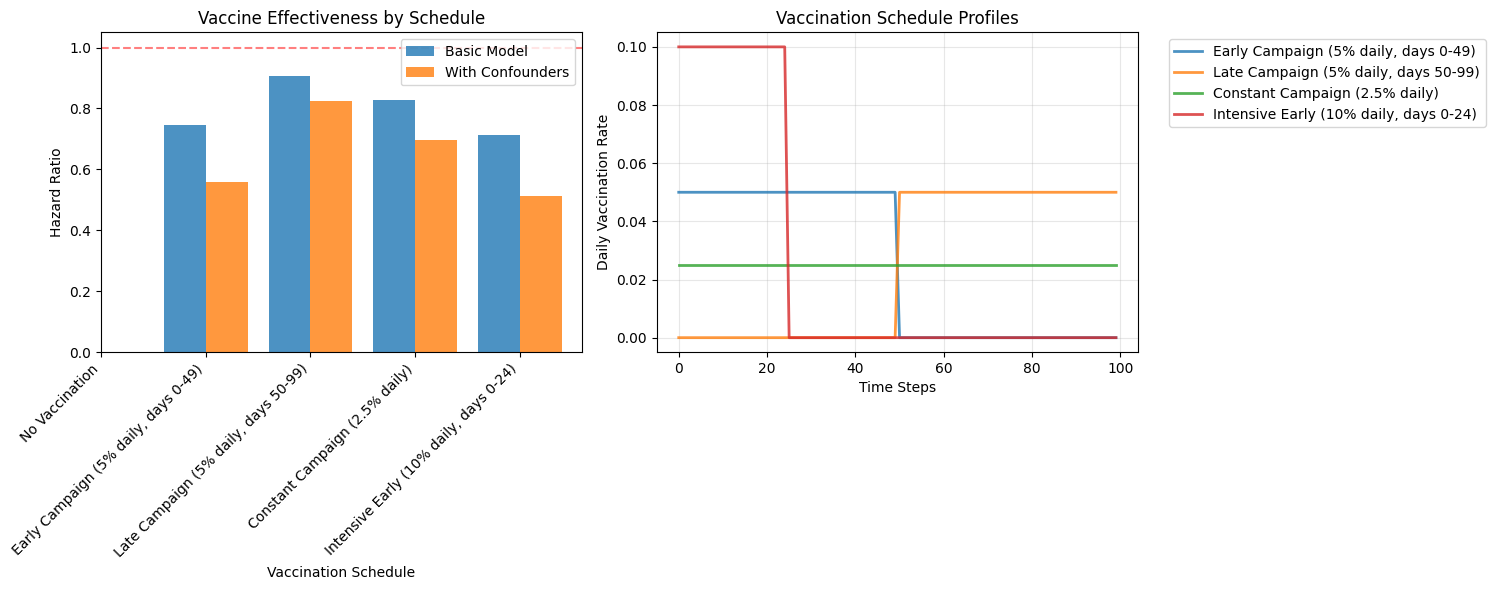

In [ ]:
# Define different vaccination schedules
vaccination_schedules = {
    'No Vaccination': [0.0] * 100,
    'Early Campaign (5% daily, days 0-49)': [0.05] * 50 + [0.0] * 50,
    'Late Campaign (5% daily, days 50-99)': [0.0] * 50 + [0.05] * 50,
    'Constant Campaign (2.5% daily)': [0.025] * 100,
    'Intensive Early (10% daily, days 0-24)': [0.10] * 25 + [0.0] * 75
}

# Run simulations for each schedule
schedule_results = {}
print("Comparing vaccination schedules...")

for schedule_name, schedule in vaccination_schedules.items():
    print(f"\nRunning: {schedule_name}")
    
    # Run simulation (no plots for comparison runs)
    G, results = run_simulation(
        **PARAMS,
        vaccination_schedule=schedule,
        outcome='tested',
        plot=False,
        print_progress=False
    )
    
    schedule_results[schedule_name] = results
    
    # Print HR if available (not for no vaccination scenario)
    if not np.isnan(results['hr_basic']):
        print(f"  HR (basic): {results['hr_basic']:.3f}")
        print(f"  HR (with confounders): {results['hr_with_unmeasured_confounder']:.3f}")
    else:
        print("  No HR available (no vaccination variation)")

# Create outcome comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Colors for different schedules
colors = plt.cm.Set1(np.linspace(0, 1, len(vaccination_schedules)))

# Plot 1: Infections over time
for i, (name, schedule) in enumerate(vaccination_schedules.items()):
    infected_data = schedule_results[name]['time_series']['infected_over_time']
    ax1.plot(range(len(infected_data)), infected_data, label=name, 
             linewidth=2, alpha=0.8, color=colors[i])

ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Number of Infected Individuals')
ax1.set_title('Infections Over Time by Vaccination Schedule')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Deaths over time
for i, (name, schedule) in enumerate(vaccination_schedules.items()):
    dead_data = schedule_results[name]['time_series']['dead_over_time']
    ax2.plot(range(len(dead_data)), dead_data, label=name, 
             linewidth=2, alpha=0.8, color=colors[i])

ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Number of Deaths')
ax2.set_title('Deaths Over Time by Vaccination Schedule')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Vaccination coverage over time
for i, (name, schedule) in enumerate(vaccination_schedules.items()):
    if name != 'No Vaccination':  # Skip the zero line
        vaccinated_data = schedule_results[name]['time_series']['vaccinated_over_time']
        ax3.plot(range(len(vaccinated_data)), vaccinated_data, label=name, 
                 linewidth=2, alpha=0.8, color=colors[i])

ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Number of Vaccinated Individuals')
ax3.set_title('Vaccination Coverage Over Time')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Plot 4: Final outcomes summary (bar plot)
schedules = list(schedule_results.keys())
final_infected = []
final_dead = []
final_vaccinated = []

for schedule in schedules:
    time_series = schedule_results[schedule]['time_series']
    final_infected.append(max(time_series['infected_over_time']) if time_series['infected_over_time'] else 0)
    final_dead.append(time_series['dead_over_time'][-1] if time_series['dead_over_time'] else 0)
    final_vaccinated.append(time_series['vaccinated_over_time'][-1] if time_series['vaccinated_over_time'] else 0)

x_pos = np.arange(len(schedules))
width = 0.25

bars1 = ax4.bar(x_pos - width, final_infected, width, label='Peak Infected', alpha=0.8, color='red')
bars2 = ax4.bar(x_pos, final_dead, width, label='Total Deaths', alpha=0.8, color='black')
bars3 = ax4.bar(x_pos + width, final_vaccinated, width, label='Total Vaccinated', alpha=0.8, color='purple')

ax4.set_xlabel('Vaccination Schedule')
ax4.set_ylabel('Number of Individuals')
ax4.set_title('Final Outcomes by Schedule')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([s.replace(' (', '\n(') for s in schedules], rotation=45, ha='right')
ax4.legend()

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== VACCINATION SCHEDULE COMPARISON ===")
for schedule in schedules:
    time_series = schedule_results[schedule]['time_series']
    peak_infected = max(time_series['infected_over_time']) if time_series['infected_over_time'] else 0
    total_dead = time_series['dead_over_time'][-1] if time_series['dead_over_time'] else 0
    total_vaccinated = time_series['vaccinated_over_time'][-1] if time_series['vaccinated_over_time'] else 0
    
    print(f"\n{schedule}:")
    print(f"  Peak infected: {peak_infected}")
    print(f"  Total deaths: {total_dead}")
    print(f"  Total vaccinated: {total_vaccinated}")
    if total_vaccinated > 0:
        print(f"  Vaccination coverage: {total_vaccinated/PARAMS['num_nodes']*100:.1f}%")

## 6. Analyze Different Outcomes

Let's compare vaccine effectiveness estimates for different outcomes: infection, testing positive, and death.

In [ ]:
# Analyze different outcomes using the same simulation graph
outcomes = ['tested', 'infected', 'death']
outcome_results = {}

print("Analyzing different outcomes from the basic simulation...")
for outcome in outcomes:
    print(f"\nAnalyzing outcome: {outcome}")
    hr_basic, hr_confounded = estimate_models(G_basic, outcome=outcome, print_results=False)
    outcome_results[outcome] = {
        'hr_basic': hr_basic,
        'hr_confounded': hr_confounded
    }
    print(f"  HR (basic): {hr_basic:.3f}")
    print(f"  HR (confounded): {hr_confounded:.3f}")

# Create comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

outcomes_list = list(outcome_results.keys())
hr_basic_vals = [outcome_results[o]['hr_basic'] for o in outcomes_list]
hr_confounded_vals = [outcome_results[o]['hr_confounded'] for o in outcomes_list]

x_pos = np.arange(len(outcomes_list))

bars1 = ax.bar(x_pos - 0.2, hr_basic_vals, 0.4, label='Basic Model', alpha=0.8, color='skyblue')
bars2 = ax.bar(x_pos + 0.2, hr_confounded_vals, 0.4, label='With Confounders', alpha=0.8, color='lightcoral')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

ax.set_xlabel('Outcome')
ax.set_ylabel('Hazard Ratio')
ax.set_title('Vaccine Effectiveness by Outcome Type')
ax.set_xticks(x_pos)
ax.set_xticklabels([o.capitalize() for o in outcomes_list])
ax.legend()
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax.set_ylim(0, max(max(hr_basic_vals), max(hr_confounded_vals)) * 1.2)

plt.tight_layout()
plt.show()

# Print interpretation
print("\n=== OUTCOME COMPARISON SUMMARY ===")
print("Lower hazard ratios indicate better vaccine effectiveness")
print("HR < 1.0: Vaccine reduces risk")
print("HR = 1.0: Vaccine has no effect") 
print("HR > 1.0: Vaccine increases risk (unexpected)")

# Calculate vaccine effectiveness (1 - HR) for each outcome
print("\nVaccine Effectiveness (1 - HR):")
for outcome in outcomes_list:
    ve_basic = (1 - outcome_results[outcome]['hr_basic']) * 100
    ve_confounded = (1 - outcome_results[outcome]['hr_confounded']) * 100
    print(f"  {outcome.capitalize()}:")
    print(f"    Basic model: {ve_basic:.1f}%")
    print(f"    With confounders: {ve_confounded:.1f}%")

## 7. Parameter Sensitivity Analysis

Let's test how sensitive our results are to changes in key parameters.

In [ ]:
# Define parameter ranges to test
sensitivity_params = {
    'vaccine_efficacy': [0.4, 0.6, 0.8, 0.9],
    'infection_prob': [0.01, 0.02, 0.03, 0.05],
    'edges_per_node': [3, 5, 7, 10]
}

# Run sensitivity analysis
sensitivity_results = {}

for param_name, param_values in sensitivity_params.items():
    print(f"\nTesting sensitivity to {param_name}...")
    sensitivity_results[param_name] = []
    
    for param_value in param_values:
        # Create modified parameters
        test_params = PARAMS.copy()
        test_params[param_name] = param_value
        
        print(f"  {param_name} = {param_value}")
        
        # Run simulation
        G, results = run_simulation(
            **test_params,
            vaccination_schedule=basic_vaccination_schedule,
            outcome='tested',
            plot=False,
            print_progress=False
        )
        
        sensitivity_results[param_name].append({
            'param_value': param_value,
            'hr_basic': results['hr_basic'],
            'hr_confounded': results['hr_with_unmeasured_confounder']
        })

# Create sensitivity plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (param_name, results) in enumerate(sensitivity_results.items()):
    ax = axes[idx]
    
    param_values = [r['param_value'] for r in results]
    hr_basic = [r['hr_basic'] for r in results]
    hr_confounded = [r['hr_confounded'] for r in results]
    
    ax.plot(param_values, hr_basic, 'o-', label='Basic Model', linewidth=2, markersize=6)
    ax.plot(param_values, hr_confounded, 's-', label='With Confounders', linewidth=2, markersize=6)
    
    ax.set_xlabel(param_name.replace('_', ' ').title())
    ax.set_ylabel('Hazard Ratio')
    ax.set_title(f'Sensitivity to {param_name.replace("_", " ").title()}')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

# Print summary table
print("\n=== SENSITIVITY ANALYSIS SUMMARY ===")
for param_name, results in sensitivity_results.items():
    print(f"\n{param_name.replace('_', ' ').title()}:")
    print("Value\tHR (Basic)\tHR (Confounded)\tVE (Basic)\tVE (Confounded)")
    for r in results:
        ve_basic = (1 - r['hr_basic']) * 100
        ve_confounded = (1 - r['hr_confounded']) * 100
        print(f"{r['param_value']}\t{r['hr_basic']:.3f}\t\t{r['hr_confounded']:.3f}\t\t{ve_basic:.1f}%\t\t{ve_confounded:.1f}%")

## 8. Monte Carlo Simulation

Run multiple simulation iterations to assess variability and create confidence intervals for our estimates.

In [ ]:
# Monte Carlo simulation settings
n_simulations = 20  # Increase this for more robust estimates
outcomes_to_test = ['tested', 'infected', 'death']

# Store results from multiple runs
mc_results = {outcome: {'hr_basic': [], 'hr_confounded': []} for outcome in outcomes_to_test}

print(f"Running {n_simulations} Monte Carlo simulations...")
print("This may take a few minutes...")

# Run multiple simulations with different random seeds
for i in tqdm(range(n_simulations), desc="Monte Carlo runs"):
    # Set different random seed for each run
    np.random.seed(i * 42)
    random.seed(i * 42)
    
    # Run simulation
    G, _ = run_simulation(
        **PARAMS,
        vaccination_schedule=basic_vaccination_schedule,
        plot=False,
        print_progress=False
    )
    
    # Analyze each outcome
    for outcome in outcomes_to_test:
        hr_basic, hr_confounded = estimate_models(G, outcome=outcome, print_results=False)
        mc_results[outcome]['hr_basic'].append(hr_basic)
        mc_results[outcome]['hr_confounded'].append(hr_confounded)

# Calculate summary statistics
print("\n=== MONTE CARLO RESULTS ===")
for outcome in outcomes_to_test:
    hr_basic_vals = mc_results[outcome]['hr_basic']
    hr_confounded_vals = mc_results[outcome]['hr_confounded']
    
    print(f"\n{outcome.capitalize()} outcome:")
    print(f"  Basic Model HR:")
    print(f"    Mean: {np.mean(hr_basic_vals):.3f}")
    print(f"    Std:  {np.std(hr_basic_vals):.3f}")
    print(f"    95% CI: [{np.percentile(hr_basic_vals, 2.5):.3f}, {np.percentile(hr_basic_vals, 97.5):.3f}]")
    
    print(f"  Confounded Model HR:")
    print(f"    Mean: {np.mean(hr_confounded_vals):.3f}")
    print(f"    Std:  {np.std(hr_confounded_vals):.3f}")
    print(f"    95% CI: [{np.percentile(hr_confounded_vals, 2.5):.3f}, {np.percentile(hr_confounded_vals, 97.5):.3f}]")

# Create box plots to show distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, outcome in enumerate(outcomes_to_test):
    ax = axes[idx]
    
    data_to_plot = [
        mc_results[outcome]['hr_basic'],
        mc_results[outcome]['hr_confounded']
    ]
    
    box_plot = ax.boxplot(data_to_plot, labels=['Basic Model', 'With Confounders'], patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel('Hazard Ratio')
    ax.set_title(f'{outcome.capitalize()} Outcome\n({n_simulations} simulations)')
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Reset random seed
np.random.seed(42)
random.seed(42)

## Conclusion

This notebook demonstrated how to use the epidemic simulation framework to:

1. **Model disease transmission** through social networks with vaccination campaigns
2. **Compare vaccination strategies** and their timing effects
3. **Analyze multiple outcomes** (infection, testing, death) from the same simulation
4. **Test parameter sensitivity** to understand which factors most affect results
5. **Quantify uncertainty** using Monte Carlo simulation

### Key Insights:
- Vaccination timing can significantly affect effectiveness estimates
- Unmeasured confounding biases vaccine effectiveness estimates
- Different outcomes (infection vs. testing vs. death) may show different effectiveness patterns
- Network connectivity and infection probability strongly influence epidemic dynamics

### Next Steps:
- Experiment with different network structures (small-world, scale-free)
- Test more complex vaccination strategies (targeted by risk, network position)
- Incorporate time-varying vaccine efficacy
- Add more realistic disease progression models

### Usage Tips:
- Adjust `n_simulations` in Monte Carlo section for more robust estimates
- Modify `PARAMS` to test different epidemic scenarios  
- Change `basic_vaccination_schedule` to test custom vaccination patterns
- Use different `outcome` parameters in `run_simulation()` to analyze various endpoints